# Joining together various data types into one big DataFrame
This notebook will accomplish many things to put together the data into a big DataFrame for downstream analyses/figures:
* Show that the two Rho libraries are calibrated
* Join together the two libraries with Rho and Polylinker
* Compute fold changes between WT and MUT sequences in the Rho assay
* Annotate sequences for their activity as WT, MUT, and Polylinker
* Annotate sequences for binding patterns with CRX, NRL, and MEF2D ChIP data

In [1]:
import os
import sys
import itertools

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
from scipy import stats
from pybedtools import BedTool
from IPython.display import display

sys.path.insert(0, "utils")
from utils import fasta_seq_parse_manip, modeling, plot_utils, sequence_annotation_processing

data_dir = os.path.join("Data")
figures_dir = os.path.join("Figures")
all_seqs = fasta_seq_parse_manip.read_fasta(os.path.join(data_dir, "library1And2.fasta"))

In [2]:
plot_utils.set_manuscript_params()

## Show reproducibility of raw data for all experiments in one figure

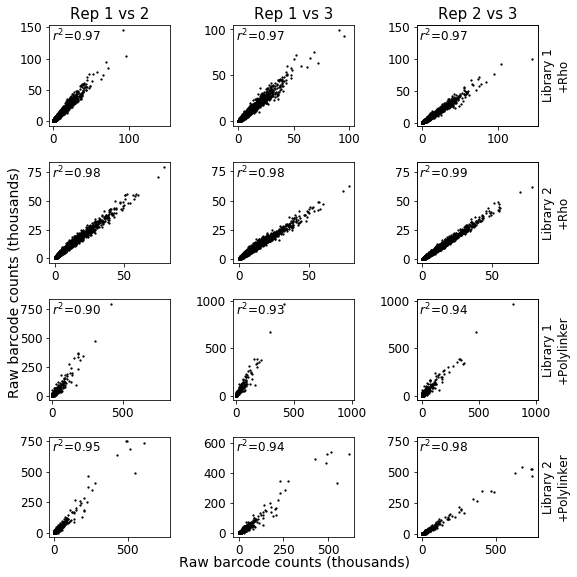

In [3]:
# File names of the raw barcode counts
raw_data_files = [os.path.join(data_dir, dirname, filename) for dirname, filename in itertools.product(["Rhodopsin", "Polylinker"], ["library1RawBarcodeCounts.txt", "library2RawBarcodeCounts.txt"])]
raw_data_names = ["Library 1\n+Rho", "Library 2\n+Rho", "Library 1\n+Polylinker", "Library 2\n+Polylinker"]
comparison_columns = ["Rep 1 vs 2", "Rep 1 vs 3", "Rep 2 vs 3"]
fig, ax_list = plt.subplots(nrows=4, ncols=3, figsize=(8, 8))

# Read in each dataset
for row, filename in enumerate(raw_data_files):
    row_df = pd.read_csv(filename, sep="\t")
    # Get all 3 pairs of combinations and plot them
    for col, (x, y) in enumerate(itertools.combinations(["RNA1", "RNA2", "RNA3"], 2)):
        rsquared = stats.pearsonr(row_df[x], row_df[y])[0] ** 2
        ax = ax_list[row, col]
        ax.scatter(row_df[x] / 1000, row_df[y] / 1000, color="k")
        ax.text(0.02, 0.98, fr"$r^2$={rsquared:.2f}", transform=ax.transAxes, ha="left", va="top")
        max_value = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.set_xlim(right=max_value)
        ax.set_ylim(top=max_value)
        
# Add "axis" labels
fig.text(0.5, 0.025, "Raw barcode counts (thousands)", ha="center", va="top", fontsize=14)
fig.text(0.025, 0.5, "Raw barcode counts (thousands)", rotation=90, ha="right", va="center", fontsize=14)

# Add column labels at the top
for col, text in enumerate(comparison_columns):
    ax_list[0, col].set_title(text)
    
# Add row labels on the right
for row, text in enumerate(raw_data_names):
    twinax = ax_list[row, 2].twinx()
    twinax.set_ylabel(text)
    twinax.set_yticks([])

plot_utils.save_fig(fig, os.path.join(figures_dir, "supplementalFigure1"), timestamp=False)

## Read in Rho data, assess calibration

Scrambled sequences from L1 and L2 are drawn from the same distribution, KS test p = 0.087, D = 0.14


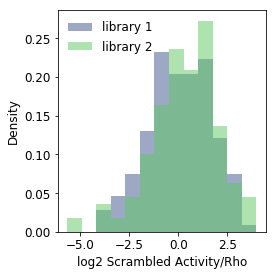

In [4]:
rho_dir = os.path.join(data_dir, "Rhodopsin")

# Read in data
library1_df = pd.read_csv(os.path.join(rho_dir, "library1TotalExpressionSummary.txt"), sep="\t", index_col=0)
library1_df["library"] = 1
library2_df = pd.read_csv(os.path.join(rho_dir, "library2TotalExpressionSummary.txt"), sep="\t", index_col=0)
library2_df["library"] = 2

# Get scrambled sequences from each library with RNA barcodes measured
scrambled_library1_df = library1_df[library1_df.index.str.contains("scrambled") & (library1_df["expression"] > 0)]
scrambled_library2_df = library2_df[library2_df.index.str.contains("scrambled") & (library2_df["expression"] > 0)]

# Compare distributions of log2 expression
scrambled_library1_expr = np.log2(scrambled_library1_df["expression"])
scrambled_library2_expr = np.log2(scrambled_library2_df["expression"])
ks_stat, pval = stats.ks_2samp(scrambled_library1_expr, scrambled_library2_expr)
print(f"Scrambled sequences from L1 and L2 are drawn from the same distribution, KS test p = {pval:.3f}, D = {ks_stat:.2f}")

# Show the two histograms
fig, ax = plt.subplots()
ax.hist([scrambled_library2_expr, scrambled_library1_expr], bins="auto", histtype="stepfilled", density=True, label=["library 2", "library 1"], color=plot_utils.set_color([0.75, 0.25]), alpha=0.5)
ax.set_xlabel("log2 Scrambled Activity/Rho")
ax.set_ylabel("Density")
ax.legend(loc="upper left", frameon=False)
plot_utils.save_fig(fig, os.path.join(figures_dir, "supplementalFigure2"), timestamp=False)

## Join two Rho libraries together, annotate sequences as strong/weak enhancer, inactive, silencer, or ambiguous

In [5]:
color_mapping = {
    "Strong enhancer": "#1f78b4",
    "Weak enhancer": "#a6cee3",
    "Inactive": "#33a02c",
    "Silencer": "#e31a1c",
    np.nan: "grey"
}

# Join the libraries and add a pseudocount to take log2
rho_df = library1_df.append(library2_df)
rho_pseudocount = 1e-3
rho_df["expression_log2"] = np.log2(rho_df["expression"] + rho_pseudocount)

# Define cutoff for a strong enhancer based on scrambled sequences
scrambled_mask = rho_df.index.str.contains("scrambled")
scrambled_df = rho_df[scrambled_mask]
scrambled_df = scrambled_df[scrambled_df["expression"].notna()]
strong_cutoff = scrambled_df["expression_log2"].quantile(0.95)
print(f"Cutoff to call something a strong enhancer: activity is above {strong_cutoff:.2f}")

# Drop scrambled sequences
rho_df = rho_df[~scrambled_mask]

# Helper function to label and color a sequence
def label_color_sequence(row, alpha=0.05, strong_cutoff=strong_cutoff, inactive_cutoff=1, color_mapping=color_mapping):
    expr_log2 = row["expression_log2"]
    qval = row["expression_qvalue"]
    # Inactive
    if (np.abs(expr_log2) <= inactive_cutoff) & (qval >= alpha):
        group = "Inactive"
    # Silencer
    elif (expr_log2 < -inactive_cutoff) & ((qval < alpha) | (row["expression"] == 0)):
        group = "Silencer"
    # Enhancer
    elif (expr_log2 > inactive_cutoff) & (qval < alpha):
        # Strong
        if expr_log2 > strong_cutoff:
            group = "Strong enhancer"
        # Weak
        else:
            group = "Weak enhancer"
    # Ambiguous
    else:
        group = np.nan
    
    color = color_mapping[group]
    return pd.Series({"group_name": group, "plot_color": color})

# Annotate both WT and MUT sequences
rho_df = rho_df.join(rho_df.apply(label_color_sequence, axis=1))
rho_df["group_name"] = sequence_annotation_processing.to_categorical(rho_df["group_name"])

# Save to file
sequence_annotation_processing.save_df(rho_df, os.path.join(data_dir, "rhoActivityJoinedAnnotated.txt"))

Cutoff to call something a strong enhancer: activity is above 2.84


## Read in Polylinker data, annotate for autonomous activity

In [6]:
polylinker_dir = os.path.join(data_dir, "Polylinker")

# Read in data
library1_poly_df = pd.read_csv(os.path.join(polylinker_dir, "library1TotalExpressionSummary.txt"), sep="\t", index_col=0)
library2_poly_df = pd.read_csv(os.path.join(polylinker_dir, "library2TotalExpressionSummary.txt"), sep="\t", index_col=0)

# Join two dataframes, compute log2
poly_df = library1_poly_df.append(library2_poly_df)
poly_pseudocount = 1e-2
poly_df["expression_log2"] = np.log2(poly_df["expression"] + poly_pseudocount)

# Annotate for autonomous activity
poly_df["autonomous_activity"] = (poly_df["expression_log2"] > 0)

# Save to file
sequence_annotation_processing.save_df(poly_df, os.path.join(data_dir, "polyActivityJoinedAnnotated.txt"))

## Compute WT vs. MUT activity in the Rho assay, join with WT Polylinker activity
Only compute effect sizes when the MUT is CRX sites (i.e. not DNA shape mutants).

In [7]:
wt_mask = rho_df.index.str.contains("_WT$")
mut_mask = rho_df.index.str.contains("_MUT-allCrxSites$")

# Add variant info as a column, then trim it off the index
rho_df_no_variant_df = rho_df.copy()
rho_df_no_variant_df["variant"] = rho_df_no_variant_df.index.str.split("_").str[2:].str.join("_")
rho_df_no_variant_df = sequence_annotation_processing.remove_mutations_from_seq_id(rho_df_no_variant_df)

# Separate out WT and MUT, then join them together on the same row
wt_df = rho_df_no_variant_df[wt_mask]
mut_df = rho_df_no_variant_df[mut_mask]
wt_vs_mut_rho_df = wt_df.join(mut_df, lsuffix="_WT", rsuffix="_MUT")
wt_vs_mut_rho_df["wt_vs_mut_log2"] = wt_vs_mut_rho_df["expression_log2_WT"] - wt_vs_mut_rho_df["expression_log2_MUT"]

# Compute parameters for lognormal distribution to do stats
wt_cov = wt_vs_mut_rho_df["expression_std_WT"] / wt_vs_mut_rho_df["expression_WT"]
wt_log_mean = np.log(wt_vs_mut_rho_df["expression_WT"] / np.sqrt(wt_cov**2 + 1))
wt_log_std = np.sqrt(np.log(wt_cov**2 + 1))
mut_cov = wt_vs_mut_rho_df["expression_std_MUT"] / wt_vs_mut_rho_df["expression_MUT"]
mut_log_mean = np.log(wt_vs_mut_rho_df["expression_MUT"] / np.sqrt(mut_cov**2 + 1))
mut_log_std = np.sqrt(np.log(mut_cov**2 + 1))

# Do t-tests and FDR
wt_vs_mut_rho_df["wt_vs_mut_pvalue"] = stats.ttest_ind_from_stats(wt_log_mean, wt_log_std, wt_vs_mut_rho_df["expression_reps_WT"], mut_log_mean, mut_log_std, wt_vs_mut_rho_df["expression_reps_MUT"], equal_var=False)[1]
wt_vs_mut_rho_df["wt_vs_mut_qvalue"] = modeling.fdr(wt_vs_mut_rho_df["wt_vs_mut_pvalue"])

# Pull out WT polylinker measurements
poly_wt_df = poly_df.copy()
poly_wt_df = poly_wt_df[poly_wt_df.index.str.contains("WT")]

# Drop the variant ID
poly_wt_df = poly_wt_df.rename(index=lambda x: x[:-3], columns={"expression": "expression_POLY", "expression_SEM": "expression_SEM_POLY", "expression_log2": "expression_log2_POLY"})

# Join with Rho
activity_df = wt_vs_mut_rho_df.join(poly_wt_df)

/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/ryan/miniconda/envs/bclab/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## Annotate for binding patterns

In [9]:
# Get info on CRX binding from the seq ID strings
activity_df["crx_bound"] = activity_df.index.str.contains("_C...$")

# Read in BED files
library_bed = BedTool(os.path.join(data_dir, "library1And2.bed"))
nrl_chip_bed = BedTool(os.path.join("Data", "Downloaded", "ChIP", "nrlPeaksMm10.bed"))
mef2d_chip_bed = BedTool(os.path.join("Data", "Downloaded", "ChIP", "mef2dPeaksMm10.bed"))

# Get binding patterns for NRL and MEF2D
library_nrl_bound_df = library_bed.intersect(nrl_chip_bed, wa=True).to_dataframe()
activity_df["nrl_bound"] = activity_df.index.isin(library_nrl_bound_df["name"])

library_mef2d_bound_df = library_bed.intersect(mef2d_chip_bed, wa=True).to_dataframe()
activity_df["mef2d_bound"] = activity_df.index.isin(library_mef2d_bound_df["name"])

# Helper function to "reverse one hot encode" binding patterns
def annotate_binding(row):
    crx, nrl, mef2d = row[["crx_bound", "nrl_bound", "mef2d_bound"]]
    if crx:
        if nrl:
            if mef2d:
                return "All three"
            else:
                return "CRX+NRL"
        elif mef2d:
            return "CRX+MEF2D"
        else:
            return "CRX only"
    elif nrl:
        if mef2d:
            return "NRL+MEF2D"
        else:
            return "NRL only"
    elif mef2d:
        return "MEF2D only"
    else:
        return "No binding"

activity_df["binding_group"] = activity_df.apply(annotate_binding, axis=1)

# Write to file
sequence_annotation_processing.save_df(activity_df, os.path.join(data_dir, "wildtypeMutantPolylinkerActivityAnnotated.txt"))

## Write different groups to file

In [10]:
out_dir = os.path.join(data_dir, "ActivityBins")

masks_variant_names = [
    (activity_df["group_name_WT"].str.contains("Strong"), "variant_WT", "strongEnhancer.fasta"),
    (activity_df["group_name_WT"].str.contains("Weak"), "variant_WT", "weakEnhancer.fasta"),
    (activity_df["group_name_WT"].str.contains("Inactive"), "variant_WT", "inactive.fasta"),
    (activity_df["group_name_WT"].str.contains("Silencer"), "variant_WT", "silencer.fasta"),
    (activity_df["group_name_WT"].str.contains("Strong") & activity_df["group_name_MUT"].str.contains("Strong"), "variant_MUT", "strongToStrong.fasta"),
    (activity_df["group_name_WT"].str.contains("Strong") & activity_df["group_name_MUT"].str.contains("Weak"), "variant_MUT", "strongToWeak.fasta"),
    (activity_df["group_name_WT"].str.contains("Strong") & activity_df["autonomous_activity"], "variant_WT", "strongAutonomousEnhancer.fasta"),
    (activity_df["group_name_WT"].str.contains("Strong") & ~(activity_df["autonomous_activity"]), "variant_WT", "strongNonautonomousEnhancer.fasta")
]

for mask, variants, name in masks_variant_names:
    mask = mask & mask.notna()
    ids = activity_df.loc[mask, variants]
    fasta_seq_parse_manip.write_fasta(all_seqs[ids.index + "_" + ids], os.path.join(out_dir, name))